In [1]:
import sys
import pandas as pd
from pathlib import Path
project_root = Path("..").resolve()
sys.path.append(str(project_root))
from ml_toolbox import HilbertEnvelopeAnalyzer, EnvelopeConfig, DataLoader, WindowConfig, WindowExtractor


# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

frequency = '10hz'
sensor_type = 'current'
load = 'no_load'
sampling_rate = 10000

healthy, healthy_metadata = data_loader.load_batch(
    condition='system_misalignment', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

# Load faulty data for comparison
faulty_data, faulty_metadata = data_loader.load_batch(
    condition='faulty_bearing', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

n_healthy = 4096
n_faulty = 4096

# Create windows
overlap_ratio = 0.5
healthy_step_size = int(n_healthy * (1 - overlap_ratio))
healthy_window_config = WindowConfig(window_size=n_healthy, 
                             step_size=healthy_step_size,
                             overlap_ratio=overlap_ratio)
healthy_extractor = WindowExtractor(healthy_window_config)
healthy_windows, healthy_win_metadata = healthy_extractor.extract_windows(healthy[0], healthy_metadata[0])

faulty_step_size = int(faulty_data[0].shape[0] * (1 - overlap_ratio))
faulty_window_config = WindowConfig(
    window_size=n_faulty,
    step_size=faulty_step_size,
    overlap_ratio=overlap_ratio
)

faulty_extractor = WindowExtractor(faulty_window_config)
faulty_windows, faulty_win_metadata = faulty_extractor.extract_windows(faulty_data[0], faulty_metadata[0])

h_w = healthy_windows[0]
h_ch1 = h_w[:, 0]
h_ch2 = h_w[:, 1]

f_w = faulty_windows[0]
f_ch1 = f_w[:, 0]
f_ch2 = f_w[:, 1]

env_conf = EnvelopeConfig(
    bandpass_low=3050.0,
    bandpass_high=3150.0,
    lowpass_cutoff=200.0,
    filter_order=4,
    decimation_factor=5,
    sampling_rate=10000 # current fs
)

analyzer = HilbertEnvelopeAnalyzer(env_conf)

h_stages = analyzer.extract_envelope_with_stages(h_ch1, return_stages=True)
f_stages = analyzer.extract_envelope_with_stages(f_ch1, return_stages=True)




INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files


D:\code\ml\health-asyn-ml\ml_toolbox\data_loader\envelope_analyzer.py:186: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 820, using nperseg = 820
  freqs, psd = welch(target_signal, fs=fs, nperseg=nperseg,


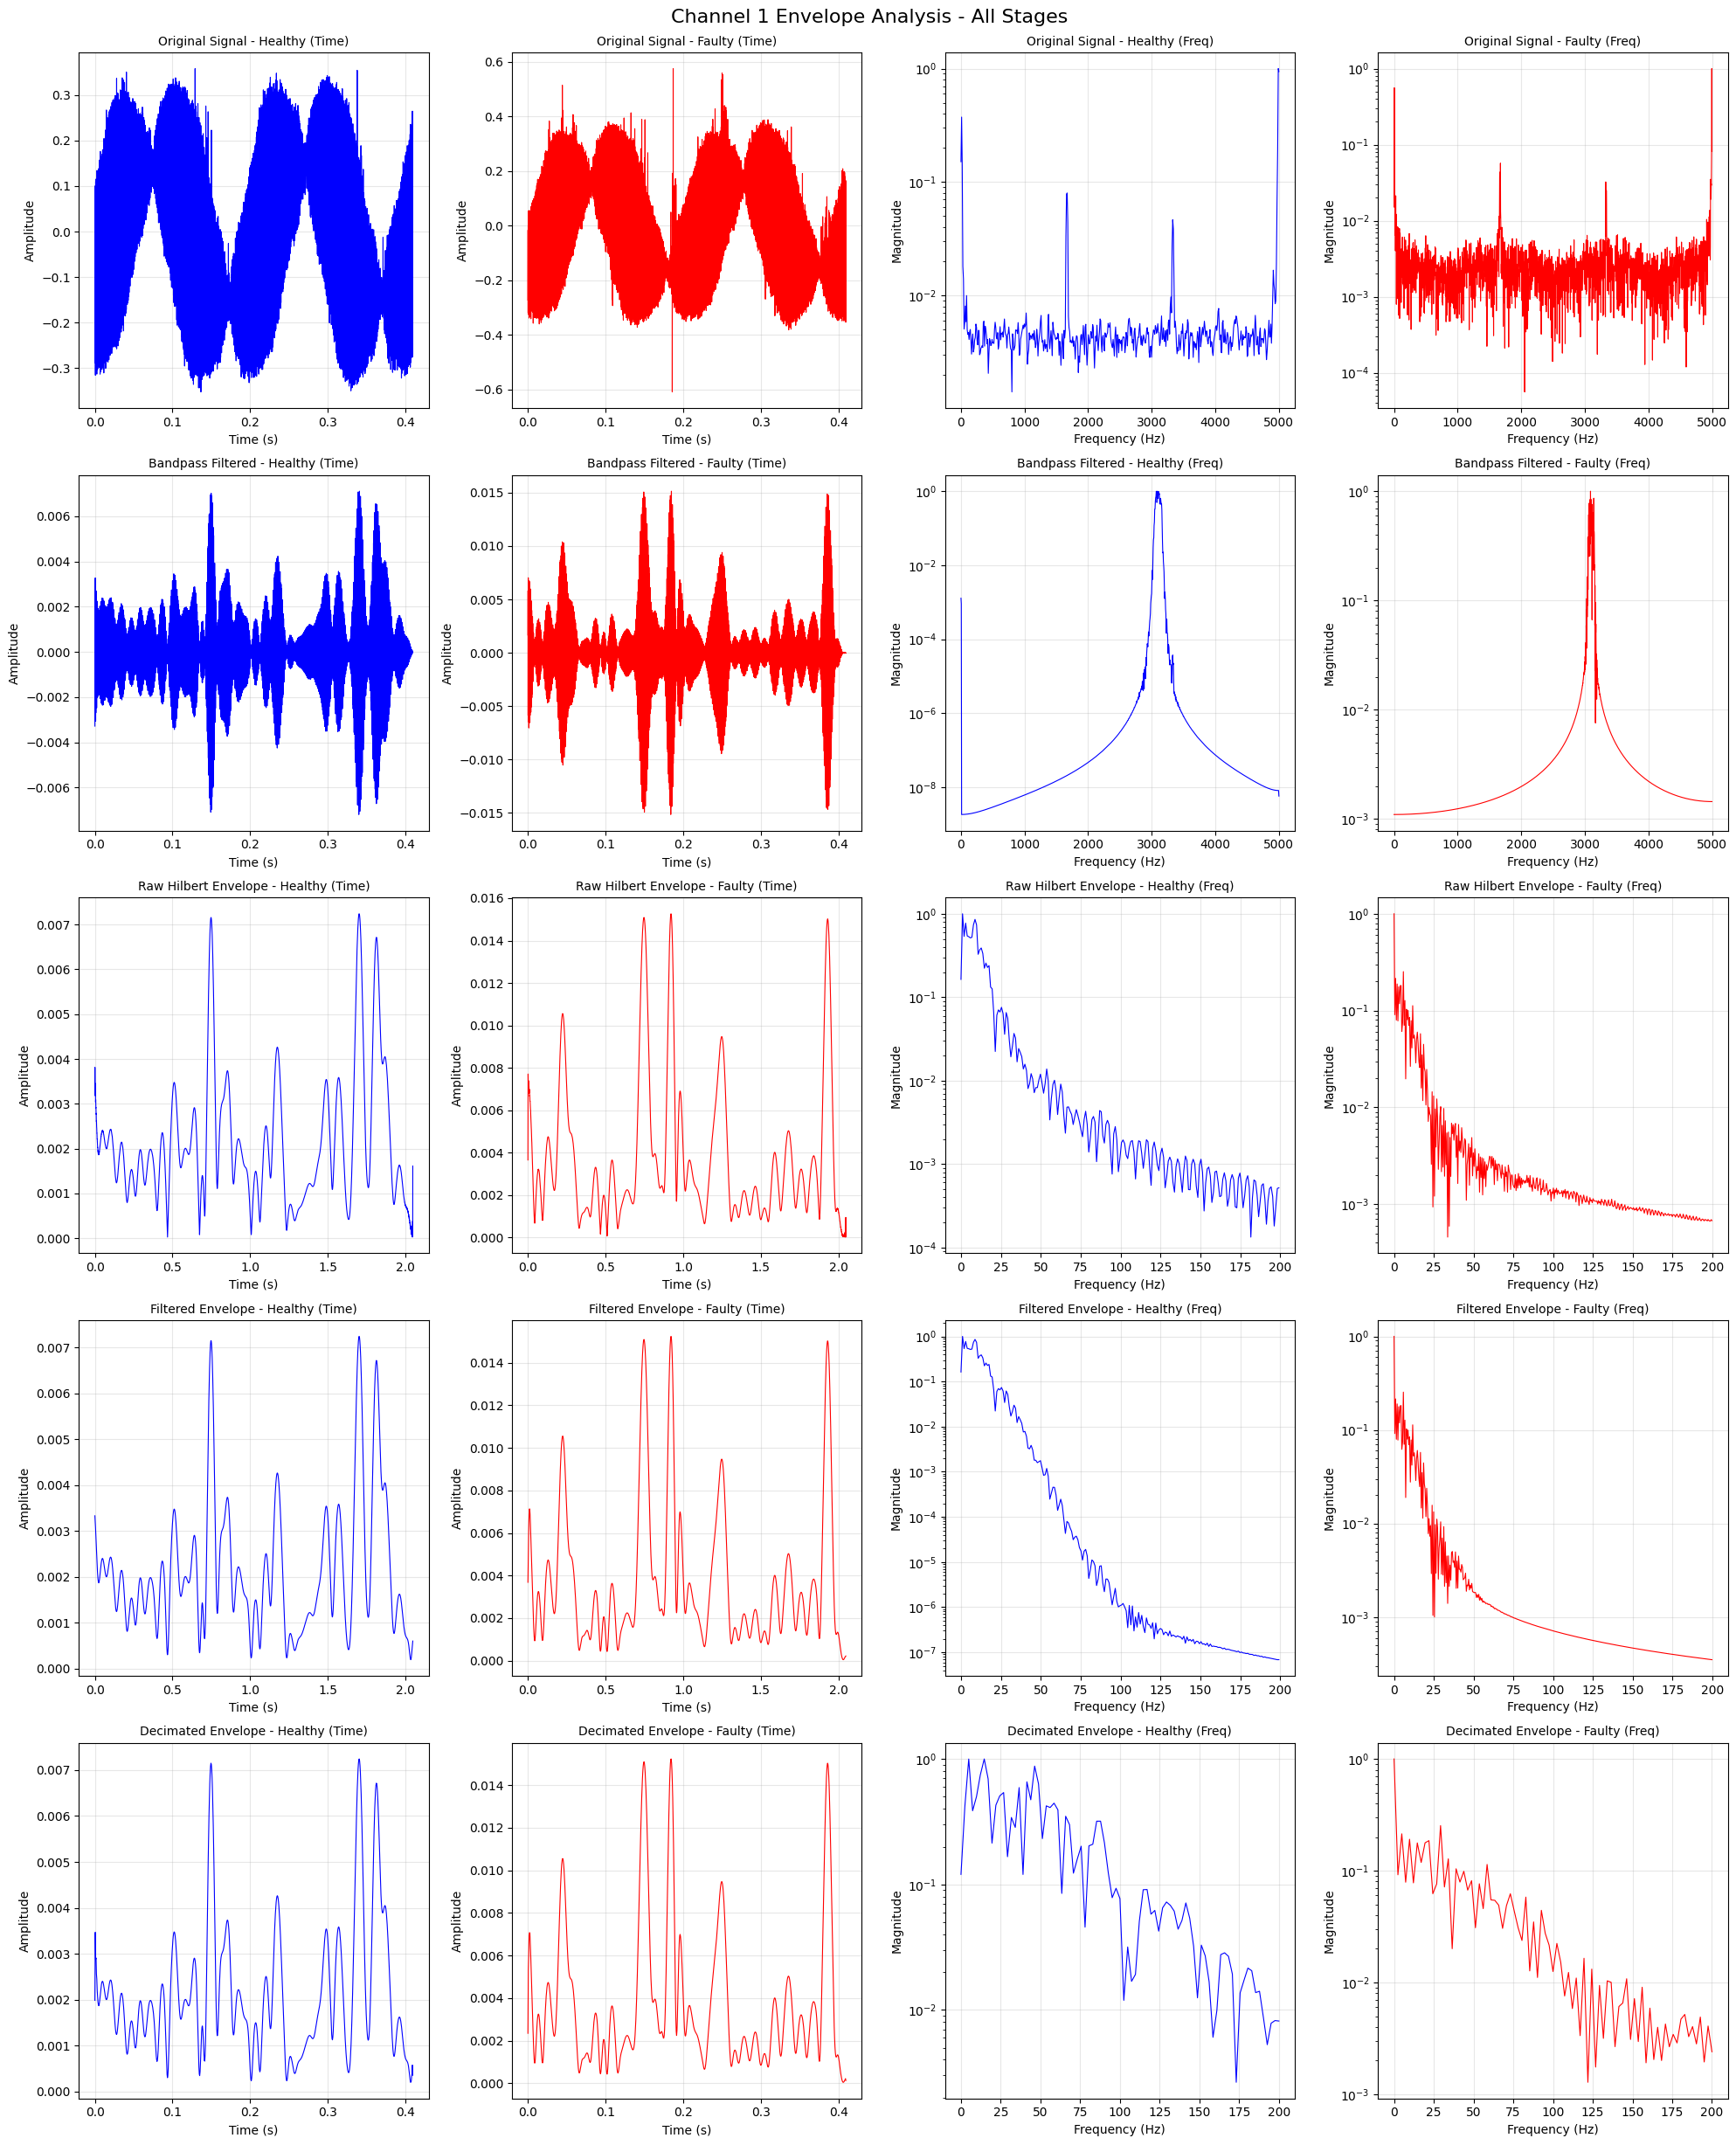

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive plots for all stages
def plot_envelope_analysis(stages_healthy, stages_faulty, analyzer_config, title_prefix=""):
    """Plot all envelope analysis stages in time and frequency domains"""
    
    # Create figure with subplots
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))
    fig.suptitle(f'{title_prefix} Envelope Analysis - All Stages', fontsize=16, y=0.98)
    
    # Stage names and their corresponding data
    stage_names = ['original', 'bandpass_filtered', 'envelope_raw', 'envelope_filtered', 'envelope_decimated']
    stage_titles = ['Original Signal', 'Bandpass Filtered', 'Raw Hilbert Envelope', 'Filtered Envelope', 'Decimated Envelope']
    
    for i, (stage_name, stage_title) in enumerate(zip(stage_names, stage_titles)):
        # Get data for current stage
        h_data = stages_healthy[stage_name]
        f_data = stages_faulty[stage_name]
        
        # Determine sampling rate for this stage
        if 'envelope' in stage_name:
            fs = analyzer_config.envelope_fs
        else:
            fs = analyzer_config.sampling_rate
        
        # Create time vectors
        h_time = np.arange(len(h_data)) / fs
        f_time = np.arange(len(f_data)) / fs
        
        # Time domain plots - Healthy
        axes[i, 0].plot(h_time, h_data, 'b-', linewidth=0.8)
        axes[i, 0].set_title(f'{stage_title} - Healthy (Time)', fontsize=10)
        axes[i, 0].set_xlabel('Time (s)')
        axes[i, 0].set_ylabel('Amplitude')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Time domain plots - Faulty
        axes[i, 1].plot(f_time, f_data, 'r-', linewidth=0.8)
        axes[i, 1].set_title(f'{stage_title} - Faulty (Time)', fontsize=10)
        axes[i, 1].set_xlabel('Time (s)')
        axes[i, 1].set_ylabel('Amplitude')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Frequency domain analysis - Healthy
        h_spectrum = analyzer.compute_fft_spectrum(stages_healthy['original'], stage_name, nperseg = 2048 if stage_name != 'original' else 1024)
        h_freqs = h_spectrum['freqs']
        h_magnitude = h_spectrum['magnitude']
        
        # Plot spectrum up to reasonable frequency limit
        freq_limit = min(fs/2, 200) if 'envelope' in stage_name else min(fs/2, 5000)
        freq_mask = h_freqs <= freq_limit
        
        axes[i, 2].plot(h_freqs[freq_mask], h_magnitude[freq_mask], 'b-', linewidth=0.8)
        axes[i, 2].set_title(f'{stage_title} - Healthy (Freq)', fontsize=10)
        axes[i, 2].set_xlabel('Frequency (Hz)')
        axes[i, 2].set_ylabel('Magnitude')
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].set_yscale('log')
        
        # Frequency domain analysis - Faulty
        f_spectrum = analyzer.compute_fft_spectrum(stages_faulty['original'], stage_name)
        f_freqs = f_spectrum['freqs']
        f_magnitude = f_spectrum['magnitude']
        
        freq_mask_f = f_freqs <= freq_limit
        
        axes[i, 3].plot(f_freqs[freq_mask_f], f_magnitude[freq_mask_f], 'r-', linewidth=0.8)
        axes[i, 3].set_title(f'{stage_title} - Faulty (Freq)', fontsize=10)
        axes[i, 3].set_xlabel('Frequency (Hz)')
        axes[i, 3].set_ylabel('Magnitude')
        axes[i, 3].grid(True, alpha=0.3)
        axes[i, 3].set_yscale('log')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.96)
    plt.show()
    
    return fig

# Plot the analysis
fig = plot_envelope_analysis(h_stages, f_stages, env_conf, "Channel 1")

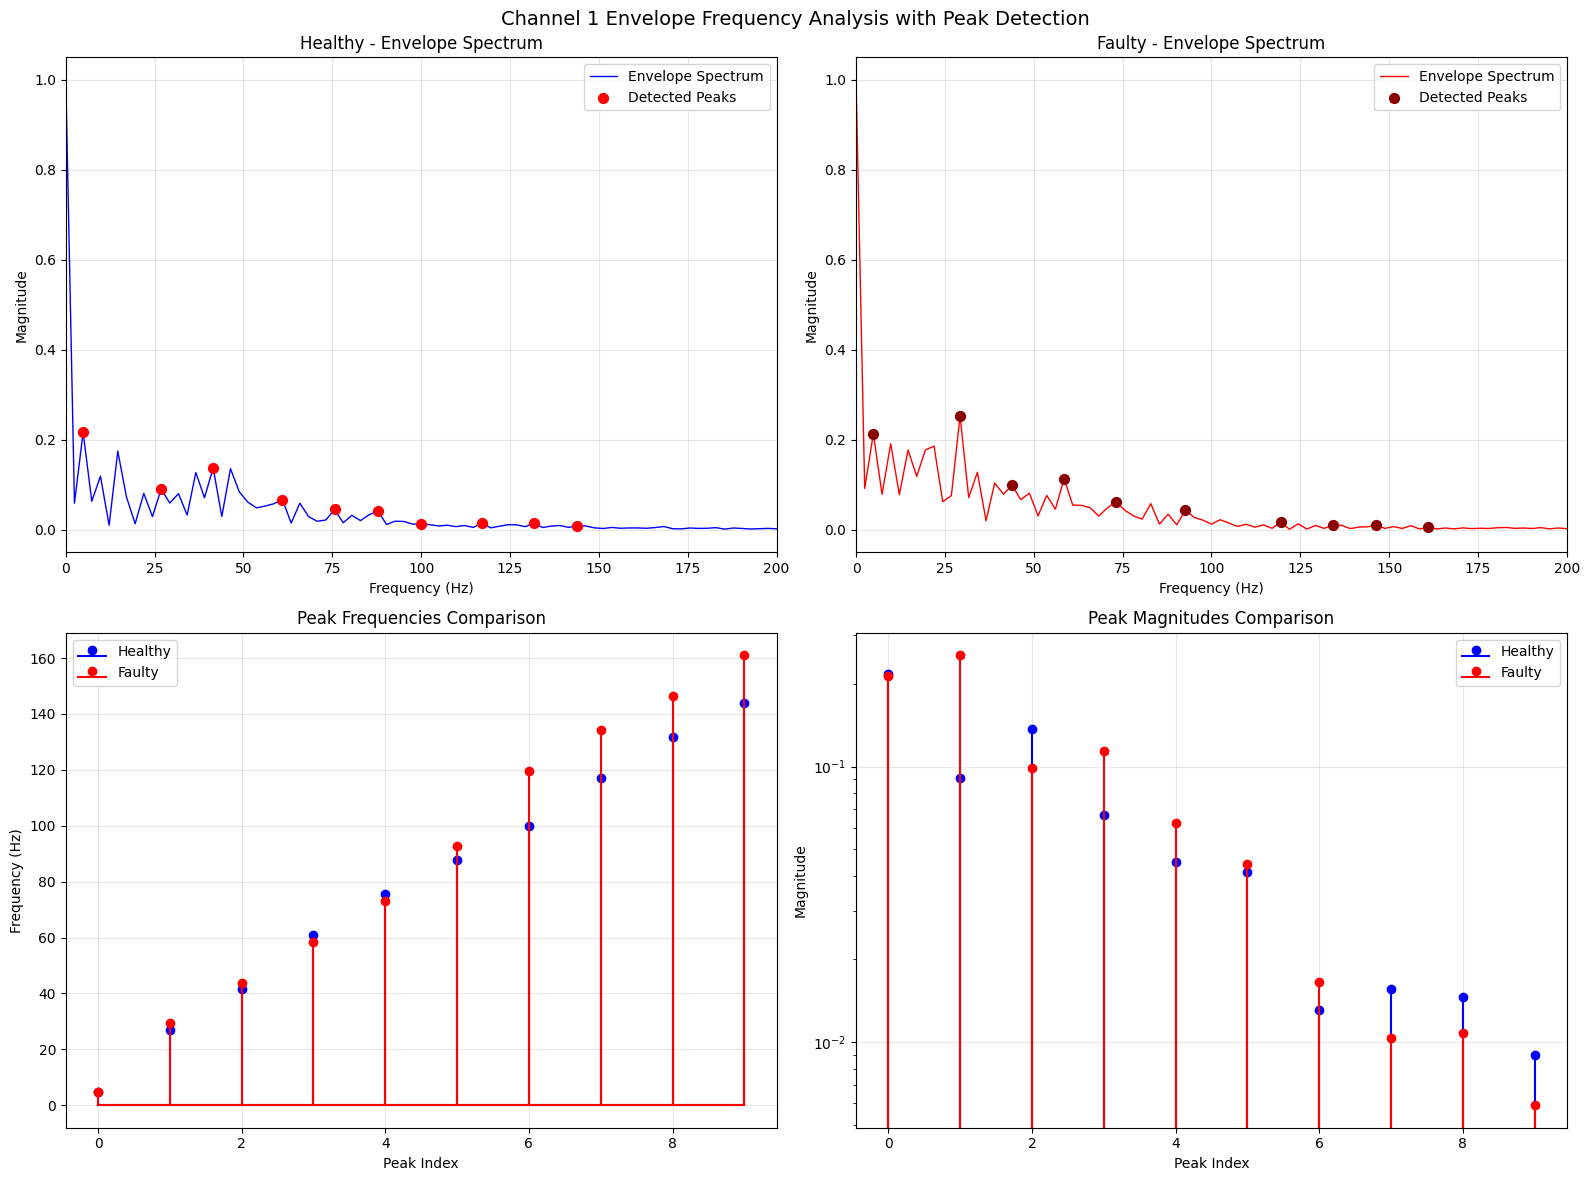


Channel 1 - Peak Analysis:

Healthy Envelope Peaks:
  Peak 1: 4.88 Hz, magnitude: 0.216788
  Peak 2: 26.83 Hz, magnitude: 0.090547
  Peak 3: 41.46 Hz, magnitude: 0.137310
  Peak 4: 60.98 Hz, magnitude: 0.066879
  Peak 5: 75.61 Hz, magnitude: 0.045113
  Peak 6: 87.80 Hz, magnitude: 0.041582
  Peak 7: 100.00 Hz, magnitude: 0.013087
  Peak 8: 117.07 Hz, magnitude: 0.015567
  Peak 9: 131.71 Hz, magnitude: 0.014552
  Peak 10: 143.90 Hz, magnitude: 0.008976

Faulty Envelope Peaks:
  Peak 1: 4.88 Hz, magnitude: 0.213842
  Peak 2: 29.27 Hz, magnitude: 0.253370
  Peak 3: 43.90 Hz, magnitude: 0.098843
  Peak 4: 58.54 Hz, magnitude: 0.113826
  Peak 5: 73.17 Hz, magnitude: 0.062197
  Peak 6: 92.68 Hz, magnitude: 0.044238
  Peak 7: 119.51 Hz, magnitude: 0.016473
  Peak 8: 134.15 Hz, magnitude: 0.010347
  Peak 9: 146.34 Hz, magnitude: 0.010800
  Peak 10: 160.98 Hz, magnitude: 0.005896

Spectrum Statistics:
Healthy - Max magnitude: 1.000000, Mean: 0.009617
Faulty  - Max magnitude: 1.000000, Mean: 0.

In [ ]:
# Detailed frequency analysis with peak detection
def plot_envelope_frequency_analysis(stages_healthy, stages_faulty, analyzer, title_prefix=""):
    """Detailed frequency analysis of envelope with peak detection"""
    
    # Get envelope spectra
    h_spectrum = analyzer.compute_fft_spectrum(stages_healthy['original'], 'envelope_decimated', nperseg=2048)
    f_spectrum = analyzer.compute_fft_spectrum(stages_faulty['original'], 'envelope_decimated', nperseg=2048)
    
    # Find peaks in the spectra
    h_peaks = analyzer.find_spectral_peaks(h_spectrum, num_peaks=10, distance=5)
    f_peaks = analyzer.find_spectral_peaks(f_spectrum, num_peaks=10, distance=5)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{title_prefix} Envelope Frequency Analysis with Peak Detection', fontsize=14)
    
    # Healthy envelope spectrum
    axes[0, 0].plot(h_spectrum['freqs'], h_spectrum['magnitude'], 'b-', linewidth=1, label='Envelope Spectrum')
    if len(h_peaks['peak_freqs']) > 0:
        axes[0, 0].scatter(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'], 
                          color='red', s=50, zorder=5, label='Detected Peaks')
    axes[0, 0].set_title('Healthy - Envelope Spectrum')
    axes[0, 0].set_xlabel('Frequency (Hz)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    axes[0, 0].set_xlim(0, 200)  # Focus on envelope frequencies
    
    # Faulty envelope spectrum
    axes[0, 1].plot(f_spectrum['freqs'], f_spectrum['magnitude'], 'r-', linewidth=1, label='Envelope Spectrum')
    if len(f_peaks['peak_freqs']) > 0:
        axes[0, 1].scatter(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'], 
                          color='darkred', s=50, zorder=5, label='Detected Peaks')
    axes[0, 1].set_title('Faulty - Envelope Spectrum')
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    axes[0, 1].set_xlim(0, 200)
    
    # Comparison of peak frequencies - handle case where no peaks found
    if len(h_peaks['peak_freqs']) > 0:
        axes[1, 0].stem(range(len(h_peaks['peak_freqs'])), h_peaks['peak_freqs'], 
                       basefmt='b-', linefmt='b-', markerfmt='bo', label='Healthy')
    if len(f_peaks['peak_freqs']) > 0:
        axes[1, 0].stem(range(len(f_peaks['peak_freqs'])), f_peaks['peak_freqs'], 
                       basefmt='r-', linefmt='r-', markerfmt='ro', label='Faulty')
    
    if len(h_peaks['peak_freqs']) == 0 and len(f_peaks['peak_freqs']) == 0:
        axes[1, 0].text(0.5, 0.5, 'No peaks detected', ha='center', va='center', 
                       transform=axes[1, 0].transAxes, fontsize=12)
    
    axes[1, 0].set_title('Peak Frequencies Comparison')
    axes[1, 0].set_xlabel('Peak Index')
    axes[1, 0].set_ylabel('Frequency (Hz)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Comparison of peak magnitudes - handle case where no peaks found
    if len(h_peaks['peak_magnitudes']) > 0:
        axes[1, 1].stem(range(len(h_peaks['peak_magnitudes'])), h_peaks['peak_magnitudes'], 
                       basefmt='b-', linefmt='b-', markerfmt='bo', label='Healthy')
    if len(f_peaks['peak_magnitudes']) > 0:
        axes[1, 1].stem(range(len(f_peaks['peak_magnitudes'])), f_peaks['peak_magnitudes'], 
                       basefmt='r-', linefmt='r-', markerfmt='ro', label='Faulty')
    
    if len(h_peaks['peak_magnitudes']) == 0 and len(f_peaks['peak_magnitudes']) == 0:
        axes[1, 1].text(0.5, 0.5, 'No peaks detected', ha='center', va='center', 
                       transform=axes[1, 1].transAxes, fontsize=12)
    else:
        axes[1, 1].set_yscale('log')
    
    axes[1, 1].set_title('Peak Magnitudes Comparison')
    axes[1, 1].set_xlabel('Peak Index')
    axes[1, 1].set_ylabel('Magnitude')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print peak information
    print(f"\n{title_prefix} - Peak Analysis:")
    print("="*50)
    
    if len(h_peaks['peak_freqs']) > 0:
        print("\nHealthy Envelope Peaks:")
        for i, (freq, mag) in enumerate(zip(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'])):
            print(f"  Peak {i+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")
    else:
        print("\nHealthy Envelope: No peaks detected with current parameters")
    
    if len(f_peaks['peak_freqs']) > 0:
        print("\nFaulty Envelope Peaks:")
        for i, (freq, mag) in enumerate(zip(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'])):
            print(f"  Peak {i+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")
    else:
        print("\nFaulty Envelope: No peaks detected with current parameters")
    
    # Print some spectrum statistics
    print(f"\nSpectrum Statistics:")
    print(f"Healthy - Max magnitude: {np.max(h_spectrum['magnitude']):.6f}, Mean: {np.mean(h_spectrum['magnitude']):.6f}")
    print(f"Faulty  - Max magnitude: {np.max(f_spectrum['magnitude']):.6f}, Mean: {np.mean(f_spectrum['magnitude']):.6f}")
    
    return fig, {'spectrum': h_spectrum, 'peaks': h_peaks}, {'spectrum': f_spectrum, 'peaks': f_peaks}

# Run the detailed frequency analysis
fig_freq, h_analysis, f_analysis = plot_envelope_frequency_analysis(h_stages, f_stages, analyzer, "Channel 1")

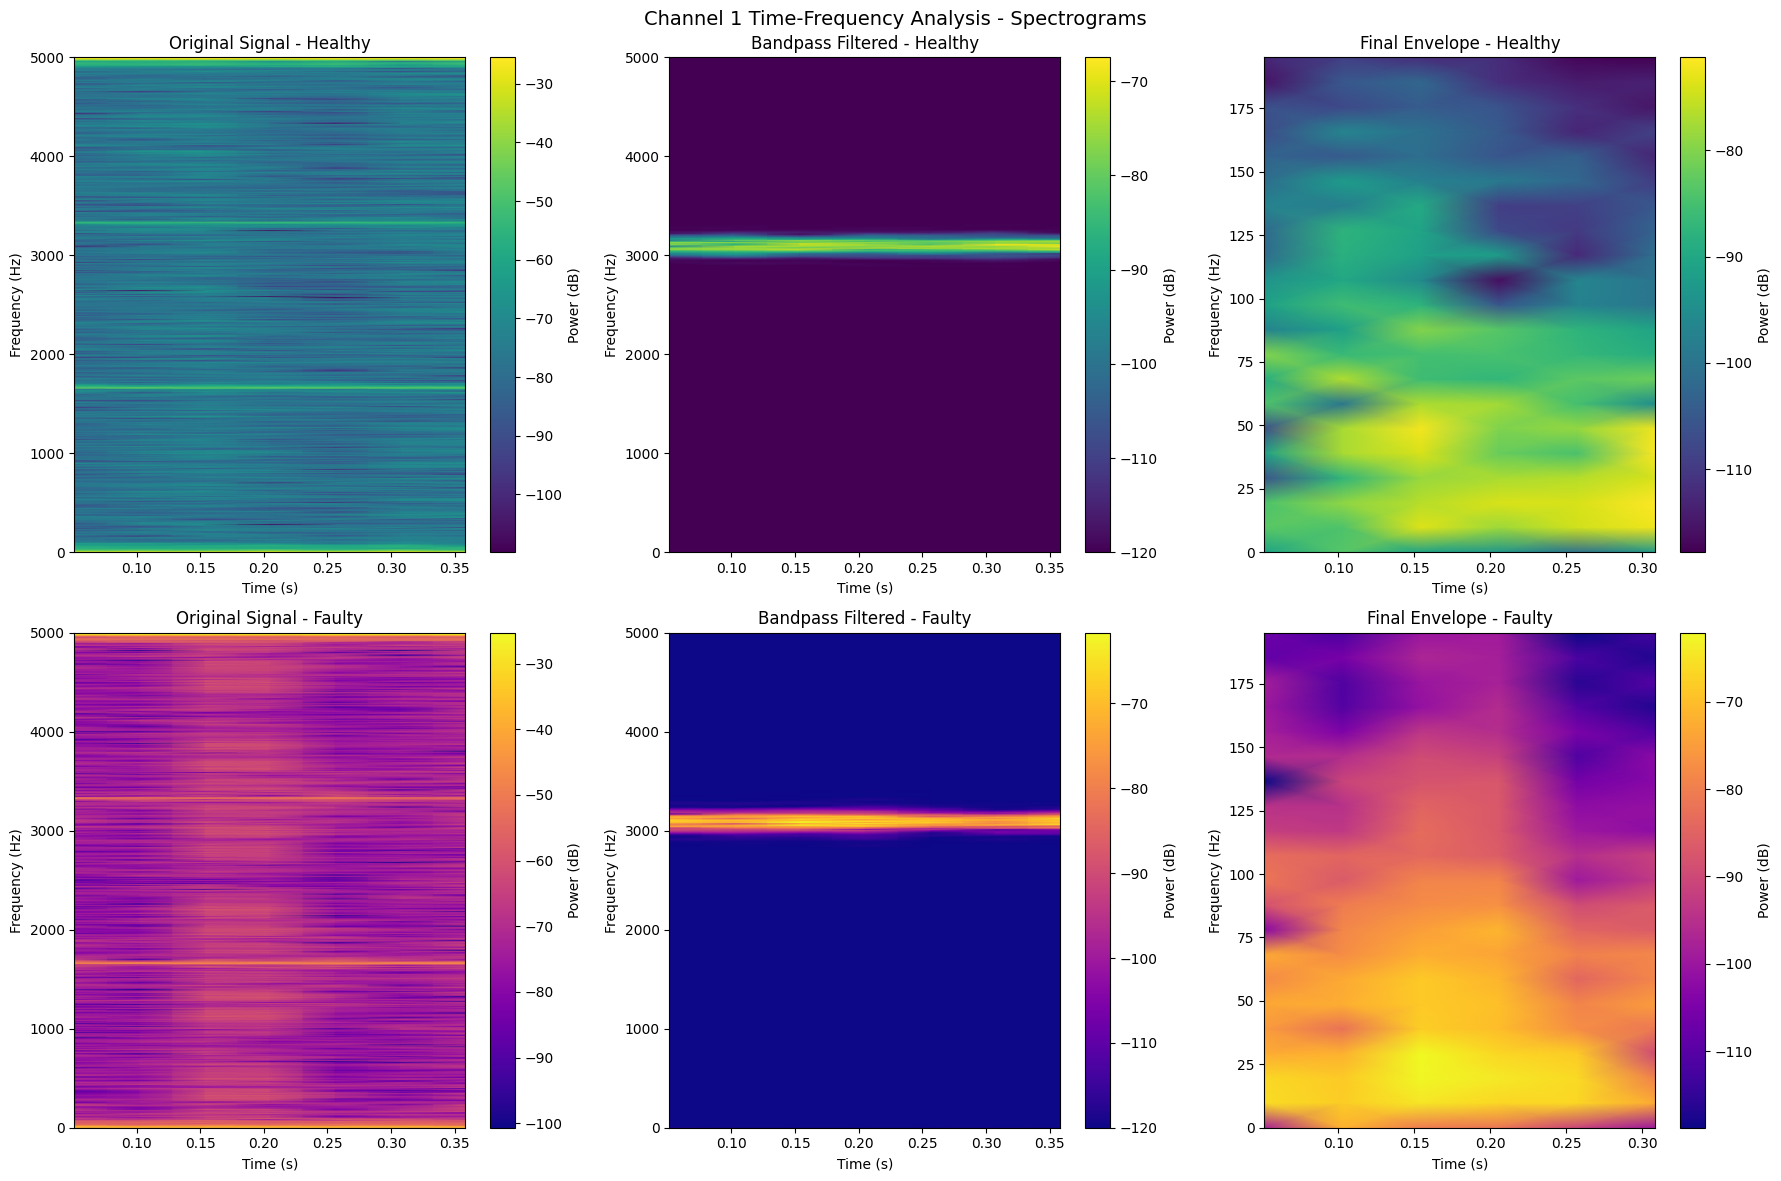

In [4]:
from scipy.signal import spectrogram

# Time-frequency analysis using spectrograms
def plot_spectrograms(stages_healthy, stages_faulty, analyzer_config, title_prefix=""):
    """Create spectrograms for time-frequency analysis"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{title_prefix} Time-Frequency Analysis - Spectrograms', fontsize=14)
    
    # Stages to analyze
    stages_to_plot = ['original', 'bandpass_filtered', 'envelope_decimated']
    stage_titles = ['Original Signal', 'Bandpass Filtered', 'Final Envelope']
    
    for i, (stage_name, stage_title) in enumerate(zip(stages_to_plot, stage_titles)):
        # Get data
        h_data = stages_healthy[stage_name]
        f_data = stages_faulty[stage_name]
        
        # Determine sampling rate and parameters
        if 'envelope' in stage_name:
            fs = analyzer_config.envelope_fs
            nperseg = min(256, len(h_data) // 4)
            freq_limit = 200
        else:
            fs = analyzer_config.sampling_rate
            nperseg = min(1024, len(h_data) // 4)
            freq_limit = 5000
        
        # Healthy spectrogram
        f_spec, t_spec, Sxx_h = spectrogram(h_data, fs=fs, nperseg=nperseg, 
                                           noverlap=nperseg//2, scaling='density')
        
        # Limit frequency range for better visualization
        freq_mask = f_spec <= freq_limit
        f_spec_limited = f_spec[freq_mask]
        Sxx_h_limited = Sxx_h[freq_mask, :]
        
        im1 = axes[0, i].pcolormesh(t_spec, f_spec_limited, 10*np.log10(Sxx_h_limited + 1e-12), 
                                   shading='gouraud', cmap='viridis')
        axes[0, i].set_title(f'{stage_title} - Healthy')
        axes[0, i].set_xlabel('Time (s)')
        axes[0, i].set_ylabel('Frequency (Hz)')
        plt.colorbar(im1, ax=axes[0, i], label='Power (dB)')
        
        # Faulty spectrogram
        f_spec_f, t_spec_f, Sxx_f = spectrogram(f_data, fs=fs, nperseg=nperseg, 
                                               noverlap=nperseg//2, scaling='density')
        
        freq_mask_f = f_spec_f <= freq_limit
        f_spec_f_limited = f_spec_f[freq_mask_f]
        Sxx_f_limited = Sxx_f[freq_mask_f, :]
        
        im2 = axes[1, i].pcolormesh(t_spec_f, f_spec_f_limited, 10*np.log10(Sxx_f_limited + 1e-12), 
                                   shading='gouraud', cmap='plasma')
        axes[1, i].set_title(f'{stage_title} - Faulty')
        axes[1, i].set_xlabel('Time (s)')
        axes[1, i].set_ylabel('Frequency (Hz)')
        plt.colorbar(im2, ax=axes[1, i], label='Power (dB)')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create spectrograms
fig_spectro = plot_spectrograms(h_stages, f_stages, env_conf, "Channel 1")


Channel 1 - Envelope Analysis Summary

Metric          Healthy      Faulty       Ratio (F/H)  Diff %    
----------------------------------------------------------------------
RMS             0.002594     0.005063     1.95         95.2      %
Peak            0.007242     0.015227     2.10         110.3     %
Mean            0.002146     0.003774     1.76         75.8      %
Std             0.001457     0.003376     2.32         131.7     %
Crest Factor    2.792147     3.007168     1.08         7.7       %
Kurtosis        2.273851     2.514483     1.11         10.6      %
Skewness        1.491082     1.739284     1.17         16.6      %

Dominant Frequencies Analysis:
----------------------------------------
Healthy Top 5 Frequencies:
  1. 4.88 Hz (magnitude: 0.216788)
  2. 14.63 Hz (magnitude: 0.174726)
  3. 36.59 Hz (magnitude: 0.127295)
  4. 41.46 Hz (magnitude: 0.137310)
  5. 46.34 Hz (magnitude: 0.135879)

Faulty Top 5 Frequencies:
  1. 4.88 Hz (magnitude: 0.213842)
  2. 9.76 Hz 

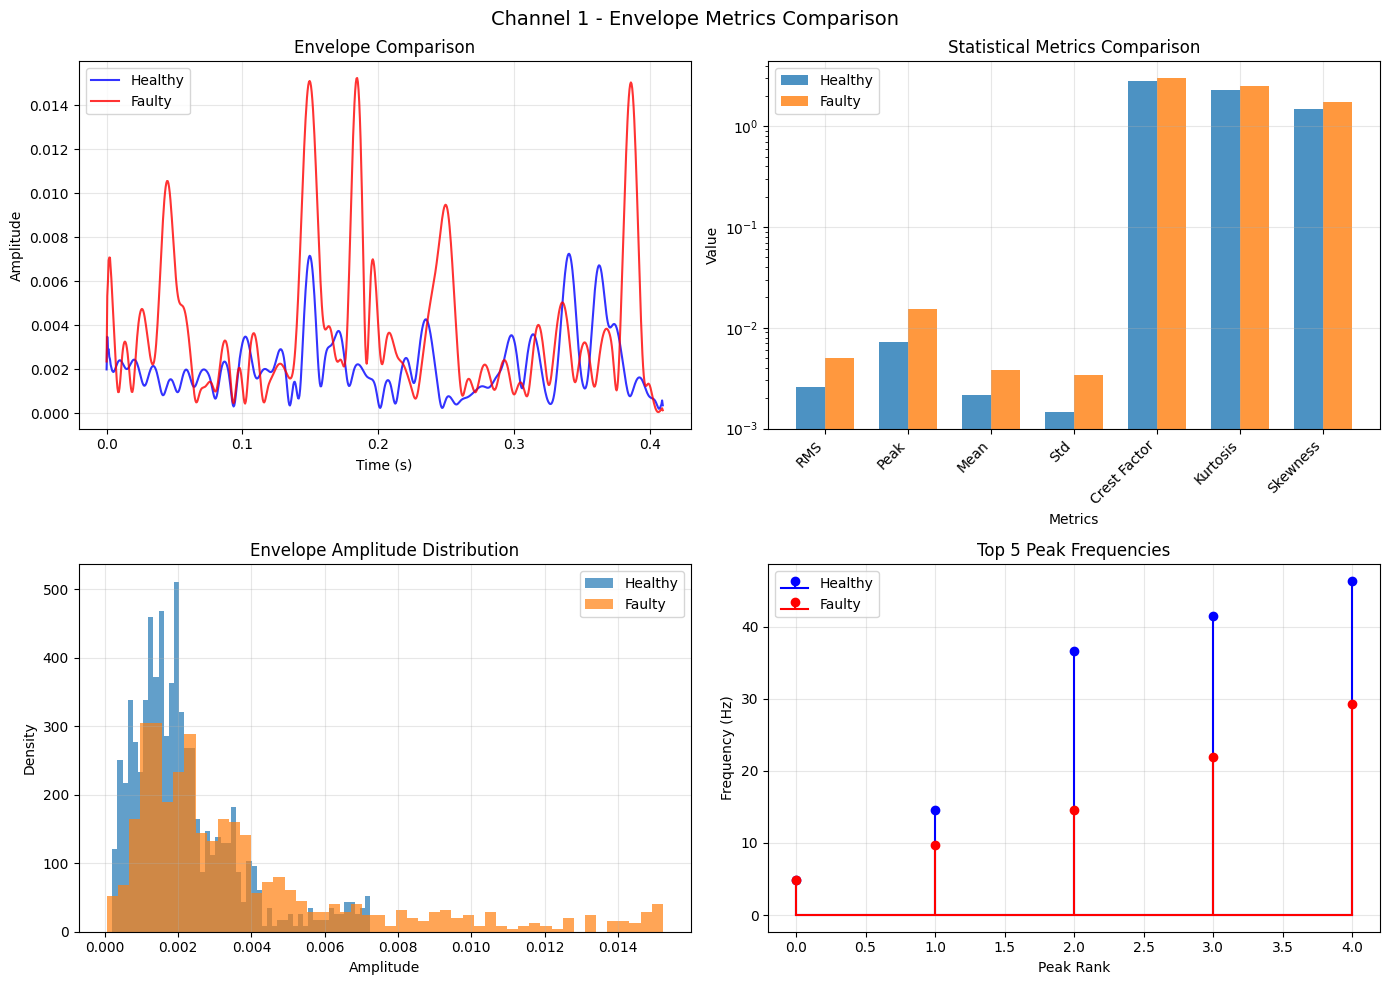

In [5]:
# Summary analysis and metrics comparison
def analyze_envelope_metrics(stages_healthy, stages_faulty, analyzer, title_prefix=""):
    """Calculate and compare envelope metrics between healthy and faulty signals"""
    
    print(f"\n{title_prefix} - Envelope Analysis Summary")
    print("="*60)
    
    # Extract final envelopes
    h_envelope = stages_healthy['envelope_decimated']
    f_envelope = stages_faulty['envelope_decimated']
    
    # Basic statistical metrics
    h_metrics = {
        'RMS': np.sqrt(np.mean(h_envelope**2)),
        'Peak': np.max(h_envelope),
        'Mean': np.mean(h_envelope),
        'Std': np.std(h_envelope),
        'Crest Factor': np.max(h_envelope) / np.sqrt(np.mean(h_envelope**2)),
        'Kurtosis': np.mean(((h_envelope - np.mean(h_envelope)) / np.std(h_envelope))**4) - 3,
        'Skewness': np.mean(((h_envelope - np.mean(h_envelope)) / np.std(h_envelope))**3)
    }
    
    f_metrics = {
        'RMS': np.sqrt(np.mean(f_envelope**2)),
        'Peak': np.max(f_envelope),
        'Mean': np.mean(f_envelope),
        'Std': np.std(f_envelope),
        'Crest Factor': np.max(f_envelope) / np.sqrt(np.mean(f_envelope**2)),
        'Kurtosis': np.mean(((f_envelope - np.mean(f_envelope)) / np.std(f_envelope))**4) - 3,
        'Skewness': np.mean(((f_envelope - np.mean(f_envelope)) / np.std(f_envelope))**3)
    }
    
    # Print comparison table
    print(f"\n{'Metric':<15} {'Healthy':<12} {'Faulty':<12} {'Ratio (F/H)':<12} {'Diff %':<10}")
    print("-" * 70)
    
    for metric in h_metrics.keys():
        h_val = h_metrics[metric]
        f_val = f_metrics[metric]
        ratio = f_val / h_val if h_val != 0 else float('inf')
        diff_pct = ((f_val - h_val) / h_val * 100) if h_val != 0 else float('inf')
        
        print(f"{metric:<15} {h_val:<12.6f} {f_val:<12.6f} {ratio:<12.2f} {diff_pct:<10.1f}%")
    
    # Frequency domain analysis - using new API
    h_spectrum = analyzer.compute_fft_spectrum(stages_healthy['original'], 'envelope_decimated')
    f_spectrum = analyzer.compute_fft_spectrum(stages_faulty['original'], 'envelope_decimated')
    
    h_peaks = analyzer.find_spectral_peaks(h_spectrum, num_peaks=5)
    f_peaks = analyzer.find_spectral_peaks(f_spectrum, num_peaks=5)
    
    h_freq_analysis = {'spectrum': h_spectrum, 'peaks': h_peaks}
    f_freq_analysis = {'spectrum': f_spectrum, 'peaks': f_peaks}
    
    print(f"\nDominant Frequencies Analysis:")
    print("-" * 40)
    
    if len(h_peaks['peak_freqs']) > 0:
        print("Healthy Top 5 Frequencies:")
        for i, (freq, mag) in enumerate(zip(h_peaks['peak_freqs'][:5], h_peaks['peak_magnitudes'][:5])):
            print(f"  {i+1}. {freq:.2f} Hz (magnitude: {mag:.6f})")
    else:
        print("Healthy: No peaks detected")
    
    if len(f_peaks['peak_freqs']) > 0:
        print("\nFaulty Top 5 Frequencies:")
        for i, (freq, mag) in enumerate(zip(f_peaks['peak_freqs'][:5], f_peaks['peak_magnitudes'][:5])):
            print(f"  {i+1}. {freq:.2f} Hz (magnitude: {mag:.6f})")
    else:
        print("\nFaulty: No peaks detected")
    
    # Energy distribution analysis
    h_total_energy = np.sum(h_spectrum['power'])
    f_total_energy = np.sum(f_spectrum['power'])
    
    print(f"\nEnergy Analysis:")
    print(f"Total Envelope Energy - Healthy: {h_total_energy:.6f}")
    print(f"Total Envelope Energy - Faulty:  {f_total_energy:.6f}")
    print(f"Energy Ratio (Faulty/Healthy):   {f_total_energy/h_total_energy:.2f}")
    
    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{title_prefix} - Envelope Metrics Comparison', fontsize=14)
    
    # Envelope comparison
    time_h = np.arange(len(h_envelope)) / analyzer.config.envelope_fs
    time_f = np.arange(len(f_envelope)) / analyzer.config.envelope_fs
    
    axes[0, 0].plot(time_h, h_envelope, 'b-', label='Healthy', alpha=0.8)
    axes[0, 0].plot(time_f, f_envelope, 'r-', label='Faulty', alpha=0.8)
    axes[0, 0].set_title('Envelope Comparison')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Statistical metrics comparison
    metrics_names = list(h_metrics.keys())
    h_values = list(h_metrics.values())
    f_values = list(f_metrics.values())
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, h_values, width, label='Healthy', alpha=0.8)
    axes[0, 1].bar(x + width/2, f_values, width, label='Faulty', alpha=0.8)
    axes[0, 1].set_title('Statistical Metrics Comparison')
    axes[0, 1].set_xlabel('Metrics')
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(metrics_names, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Histogram comparison
    axes[1, 0].hist(h_envelope, bins=50, alpha=0.7, label='Healthy', density=True)
    axes[1, 0].hist(f_envelope, bins=50, alpha=0.7, label='Faulty', density=True)
    axes[1, 0].set_title('Envelope Amplitude Distribution')
    axes[1, 0].set_xlabel('Amplitude')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Peak frequencies comparison
    if len(h_peaks['peak_freqs']) > 0 or len(f_peaks['peak_freqs']) > 0:
        h_freqs = h_peaks['peak_freqs'][:5] if len(h_peaks['peak_freqs']) > 0 else []
        f_freqs = f_peaks['peak_freqs'][:5] if len(f_peaks['peak_freqs']) > 0 else []
        
        if len(h_freqs) > 0:
            axes[1, 1].stem(range(len(h_freqs)), h_freqs, basefmt='b-', linefmt='b-', 
                           markerfmt='bo', label='Healthy')
        if len(f_freqs) > 0:
            axes[1, 1].stem(range(len(f_freqs)), f_freqs, basefmt='r-', linefmt='r-', 
                           markerfmt='ro', label='Faulty')
        
        axes[1, 1].set_title('Top 5 Peak Frequencies')
        axes[1, 1].set_xlabel('Peak Rank')
        axes[1, 1].set_ylabel('Frequency (Hz)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No peaks detected', ha='center', va='center', 
                       transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Top 5 Peak Frequencies')
    
    plt.tight_layout()
    plt.show()
    
    return h_metrics, f_metrics, h_freq_analysis, f_freq_analysis

# Run comprehensive analysis
h_metrics, f_metrics, h_freq_full, f_freq_full = analyze_envelope_metrics(h_stages, f_stages, analyzer, "Channel 1")